In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

### 고객의 전체 모습 파악

#### 1: 데이터 읽고 확인

In [3]:
# 어떠한 고객이 언제 센터를 이용했는 지 확인
uselog = pd.read_csv('./03.고객의전체모습파악/Data-in/use_log.csv')
print(len(uselog))
uselog.head()

197428


,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


In [4]:
# 회원 데이터
# is_deleted : 탈퇴한 유저를 빨리 찾기 위한 필드
# name은 마스킹 되어 있어서, name으로 개인을 특정짓기 힘듬
customer = pd.read_csv('./03.고객의전체모습파악/Data-in/customer_master.csv')
print(len(customer))
customer.head()

4192


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0


In [5]:
class_master = pd.read_csv('./03.고객의전체모습파악/Data-in/class_master.csv')
print(len(class_master))
class_master.head()

3


,class,class_name,price
0,C01,0_종일,10500
1,C02,1_주간,7500
2,C03,2_야간,6000


In [6]:
campaign_master = pd.read_csv('./03.고객의전체모습파악/Data-in/campaign_master.csv')
print(len(class_master))
campaign_master.head()

3


,campaign_id,campaign_name
0,CA1,2_일반
1,CA2,0_입회비반액할인
2,CA3,1_입회비무료


#### 2: 고객 데이터를 가공

In [7]:
## 기준 데이터 : 고객 데이터(customer), 이용 이력 데이터(uselog)

In [8]:
customer_join = pd.merge(customer, class_master, on = 'class', how = 'left')
customer_join = pd.merge(customer_join, campaign_master, on = 'campaign_id', how = 'left')
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0,2_야간,6000,2_일반


In [9]:
print(len(customer))
print(len(customer_join))

4192
4192


In [10]:
customer_join.isna().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
dtype: int64

#### 3: 고객 데이터 집계

In [11]:
## 집계 항목
    # 어떤 회원과 어떤 캠페인이 많은가
    # 언제 입회/ 탈퇴가 많은가
    # 남녀 비율을 어떠한가
    # 탈퇴할 때까지의 기간은 어느 정도인가

- 캠페인 구분과 성별, 이미 탈퇴했는 지 안했는 지 (is_delete열)

In [12]:
## class_name에 따른 count 
# 결과 : 회원 클래스 중 일반이 거의 절반을 차지. 종일 > 주간 > 야간
customer_join.groupby('class_name').count()['customer_id']

class_name
0_종일    2045
1_주간    1019
2_야간    1128
Name: customer_id, dtype: int64

In [13]:
## campaign_name에 따른 count
# 결과 : 일반 입회 회원이 가장 많음. 일반 > 입회 캠페인에 의한 가입
customer_join.groupby('campaign_name').count()['customer_id']

campaign_name
0_입회비반액할인     650
1_입회비무료       492
2_일반         3050
Name: customer_id, dtype: int64

In [14]:
## 성별에 따른 count
# 결과 : 남 비율 > 여 비율
customer_join[['gender','customer_id']].groupby('gender').count()

,customer_id
gender,
F,1983
M,2209


In [15]:
## 가입/탈퇴 회원 count
# 결과 : 2019년 3월 기준, 가입된 회원 = 2842명 탈퇴 회원 = 1350명
customer_join[['is_deleted','customer_id']].groupby('is_deleted').count()

,customer_id
is_deleted,
0,2842
1,1350


In [23]:
## 2018/4/1 ~ 2019/3/31 가입 인원을 집계
customer_join['start_date'] = pd.to_datetime(customer_join['start_date'])
customer_start = customer_join.loc[customer_join['start_date'] > pd.to_datetime('20180401')]
print(len(customer_start))

1361


#### 4: 최근 고객 데이터를 집계

In [ ]:
## 가장 최근 월의 고객 추출 
    # 방법 1 : 2019/3/31에 탈퇴한 고객과 재적 중인 고객을 추출
    # 방법 2 : is_deleted 열로 추출, 2019/3에 탈퇴한 고객은 카운트 되지 않는다.

In [25]:
customer_join['end_date'] = pd.to_datetime(customer_join['end_date'])
customer_newer = customer_join.loc[(customer_join['end_date'] >= pd.to_datetime('20190331')) | (customer_join['end_date'].isna())]
print(len(customer_newer))

2953


In [26]:
customer_newer['end_date'].unique()

<DatetimeArray>
['NaT', '2019-03-31 00:00:00']
Length: 2, dtype: datetime64[ns]

In [28]:
# 전체 집계(탈퇴외원 포함)에서 일반 회원의 비중은 72%, 입적회원집계 : 81% 
# 결과 : 입회 캠페인은 회원 비율 변화에 영향을 미침.
customer_newer.groupby('campaign_name').count()['customer_id']

campaign_name
0_입회비반액할인     311
1_입회비무료       242
2_일반         2400
Name: customer_id, dtype: int64

In [29]:
# 결과 : 성별에 의해 탈퇴한 비중은 높지 않음
customer_newer.groupby('gender').count()['customer_id']

gender
F    1400
M    1553
Name: customer_id, dtype: int64

#### 5: 이용 이력 데이터를 집계

In [ ]:
## 시간적인 요소 분석 가능
    # 한 달 이용 횟수의 변화
    # 회원이 스포츠 센터를 정기적/비정기적으로 이용하는가?

* 월 이용 횟수의 평균값, 중앙값, 최댓값, 최솟값, 정기적 이용 여부의 플래그 작성 후 고객 데이터에 추가

In [49]:
## 고객마다 월 이용 횟수를 집계

uselog['usedate'] = pd.to_datetime(uselog['usedate'])
uselog['연월'] = uselog['usedate'].dt.strftime('%Y%m')

In [50]:
uselog_months = uselog.groupby(['연월', 'customer_id'], as_index = False).count()
uselog_months                          # as_index : 그룹화할 내용을 인덱스로 할지 여부. False면 기존 인덱스가 유지된다.

,연월,customer_id,log_id,usedate
0,201804,AS002855,4,4
1,201804,AS009013,2,2
2,201804,AS009373,3,3
3,201804,AS015315,6,6
4,201804,AS015739,7,7
...,...,...,...,...
36837,201903,TS995853,8,8
36838,201903,TS998593,8,8
36839,201903,TS999079,3,3
36840,201903,TS999231,6,6


In [51]:
uselog_months.rename(columns = {'log_id' : 'count'}, inplace = True)
del uselog_months['usedate']
uselog_months

,연월,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7
...,...,...,...
36837,201903,TS995853,8
36838,201903,TS998593,8
36839,201903,TS999079,3
36840,201903,TS999231,6


In [76]:
uselog_customer = uselog_months.groupby('customer_id')['count'].agg(['mean', 'median', 'max', 'min'])
uselog_customer = uselog_customer.reset_index(drop = False)
uselog_customer.head()

,customer_id,mean,median,max,min
0,AS002855,4.500000,5.0,7,2
1,AS008805,4.000000,4.0,8,1
2,AS009013,2.000000,2.0,2,2
3,AS009373,5.083333,5.0,7,3
4,AS015233,7.545455,7.0,11,4


In [54]:
uselog_customer = uselog_months[['customer_id', 'count']].groupby('customer_id').agg(['mean', 'median', 'max', 'min'])
uselog_customer = uselog_customer.reset_index(drop = False)
uselog_customer.head()

customer_id     count               
                   mean median max min
0    AS002855  4.500000    5.0   7   2
1    AS008805  4.000000    4.0   8   1
2    AS009013  2.000000    2.0   2   2
3    AS009373  5.083333    5.0   7   3
4    AS015233  7.545455    7.0  11   4

#### 6: 이용 이력 데이터로부터 정기이용 여부 플래그를 작성

In [ ]:
## 정기적 : 매주 같은 요일에 왔는 지 아닌 지로 판단
# 월별 정기적 이용 여부 : 고객마다 월/요일별로 집계
# 최댓값이 4이상인 요일이 하나라도 있는 회원은 플래그를 1로 처리 

In [55]:
# 고객마다 월/요일별로 집계

# 요일을 숫자로 변환 : 0~6까지 숫자(월~일요일)
uselog['weekday'] = uselog['usedate'].dt.weekday # 요일을 숫자로 변환
uselog

,log_id,customer_id,usedate,연월,weekday
0,L00000049012330,AS009373,2018-04-01,201804,6
1,L00000049012331,AS015315,2018-04-01,201804,6
2,L00000049012332,AS040841,2018-04-01,201804,6
3,L00000049012333,AS046594,2018-04-01,201804,6
4,L00000049012334,AS073285,2018-04-01,201804,6
...,...,...,...,...,...
197423,L00000049209753,TS977703,2019-03-31,201903,6
197424,L00000049209754,TS979550,2019-03-31,201903,6
197425,L00000049209755,TS995299,2019-03-31,201903,6
197426,L00000049209756,TS995853,2019-03-31,201903,6


In [59]:
flag = uselog['customer_id'] == 'AS002855'
uselog.loc[flag]

,log_id,customer_id,usedate,연월,weekday
3110,L00000049015440,AS002855,2018-04-07,201804,5
6826,L00000049019156,AS002855,2018-04-14,201804,5
10787,L00000049023117,AS002855,2018-04-21,201804,5
14815,L00000049027145,AS002855,2018-04-28,201804,5
18448,L00000049030778,AS002855,2018-05-05,201805,5
22128,L00000049034458,AS002855,2018-05-12,201805,5
24365,L00000049036695,AS002855,2018-05-16,201805,2
26050,L00000049038380,AS002855,2018-05-19,201805,5
30016,L00000049042346,AS002855,2018-05-26,201805,5
33883,L00000049046213,AS002855,2018-06-02,201806,5


In [56]:
# 고객, 연월, 요일별로 log_id를 count
# 결과 : AS002855는 201804에 5(토) 4번, 201805에 5(토) 4번, 201806에 5(토) 5번 
# AS002855는 체육관을 토요일에 항상 오는 날로 생각함.
uselog_weekday = uselog.groupby(['customer_id', '연월', 'weekday'], as_index = False).count()[['customer_id','연월','weekday','log_id']]
uselog_weekday.rename(columns = {'log_id' : 'count'}, inplace = True)
uselog_weekday.head()

,customer_id,연월,weekday,count
0,AS002855,201804,5,4
1,AS002855,201805,2,1
2,AS002855,201805,5,4
3,AS002855,201806,5,5
4,AS002855,201807,1,1


In [67]:
## 고객별로 최댓값(특정 월, 특정 요일에 가장 많이 이용한 횟수)가 4 이상인 경우에 routine_flg를 1로 지정
uselog_weekday = uselog_weekday.groupby('customer_id', as_index= False).max()[['customer_id', 'count']]
uselog_weekday['routine_flg'] = 0 
uselog_weekday['routine_flg'] = uselog_weekday['routine_flg'].where(uselog_weekday['count'] < 4, 1)
uselog_weekday.head()

,customer_id,count,routine_flg
0,AS002855,5,1
1,AS008805,4,1
2,AS009013,2,0
3,AS009373,5,1
4,AS015233,5,1


#### 7: 고객 데이터와 이용 이력 데이터를 결합

In [79]:
# customer_join + uselog_customer
# customer_join + uselog_weekday
customer_join = pd.merge(customer_join, uselog_customer, on = 'customer_id', how = 'left')
customer_join = pd.merge(customer_join, uselog_weekday[['customer_id','routine_flg']], on = 'customer_id', how = 'left')
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,연월,mean,median,max,min,routine_flg
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,201505,4.833333,5.0,8,2,1
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,201505,5.083333,5.0,7,3,1
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,201505,4.583333,5.0,6,3,1
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,201505,4.833333,4.5,7,2,1
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,2_야간,6000,2_일반,201505,3.916667,4.0,6,1,1


In [80]:
customer_join.isna().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
연월                  0
mean                0
median              0
max                 0
min                 0
routine_flg         0
dtype: int64

#### 8: 회원 기간을 계산

In [82]:
## start_date와 end_date의 차이

from dateutil.relativedelta import relativedelta

customer_join['calc_date'] = customer_join['end_date']
customer_join['calc_date'] = customer_join['calc_date'].fillna(pd.to_datetime('20190430'))

customer_join['membership_period'] = 0
for i in range(len(customer_join)):
    delta = relativedelta(customer_join['calc_date'].iloc[i], customer_join['start_date'].iloc[i])  # 차이값을 도출하는 함수
    customer_join['membership_period'].iloc[i] = delta.years * 12 + delta.months
customer_join.head()


### 시계열 데이터를 빼고 더하고 핸들링 하는 거 익히기

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,연월,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,201505,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,201505,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,201505,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,201505,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,2_야간,6000,2_일반,201505,3.916667,4.0,6,1,1,2019-04-30,47


#### 9: 고객 행동의 각종 통계량을 파악

In [83]:
customer_join[['mean', 'median', 'max', 'min']].describe()

,mean,median,max,min
count,4192.000000,4192.000000,4192.000000,4192.000000
mean,5.333127,5.250596,7.823950,3.041269
std,1.777533,1.874874,2.168959,1.951565
min,1.000000,1.000000,1.000000,1.000000
25%,4.250000,4.000000,7.000000,2.000000
50%,5.000000,5.000000,8.000000,3.000000
75%,6.416667,6.500000,9.000000,4.000000
max,12.000000,12.000000,14.000000,12.000000


In [88]:
customer_join[['routine_flg','customer_id']].groupby('routine_flg').count()

,customer_id
routine_flg,
0,779
1,3413


In [85]:
import matplotlib.pyplot as plt

(array([857., 774., 395., 368., 311., 331., 323., 237., 288., 308.]),
 array([ 1. ,  5.6, 10.2, 14.8, 19.4, 24. , 28.6, 33.2, 37.8, 42.4, 47. ]),
 <BarContainer object of 10 artists>)

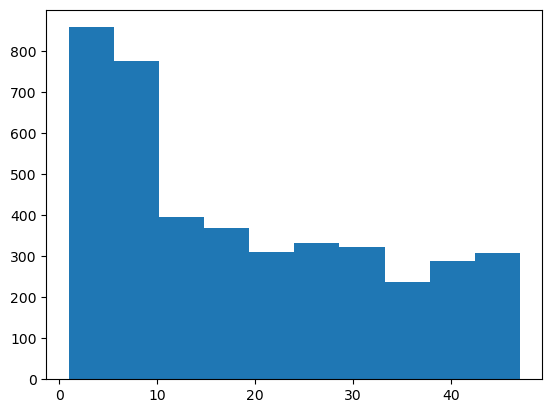

In [86]:
## 회원 기간의 분포
# 결론 : 회원 기간이 10개월 이내인 고객이 많음, 고객의 수는 거의 일정
# 짧은 기간에 고객이 빠져나가는 업계
plt.hist(customer_join['membership_period'])

#### 10: 탈퇴 회원과 지속 회원의 차이를 파악

In [91]:
## 탈퇴 회원 : 1350명, 지속회원 : 2840명

# 탈퇴 회원 
customer_end = customer_join.loc[customer_join['is_deleted'] == 1]
customer_end.describe()

,start_date,end_date,is_deleted,price,mean,median,max,min,routine_flg,calc_date,membership_period
count,1350,1350,1350.0,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350,1350.000000
mean,2018-01-20 10:45:20,2018-10-17 16:23:28,1.0,8595.555556,3.865474,3.621852,6.461481,1.821481,0.456296,2018-10-17 16:23:28,8.026667
min,2016-05-01 00:00:00,2018-04-30 00:00:00,1.0,6000.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2018-04-30 00:00:00,1.000000
25%,2017-10-01 00:00:00,2018-06-30 00:00:00,1.0,6000.000000,3.000000,3.000000,4.000000,1.000000,0.000000,2018-06-30 00:00:00,4.000000
50%,2018-03-01 00:00:00,2018-10-31 00:00:00,1.0,7500.000000,4.000000,4.000000,7.000000,2.000000,0.000000,2018-10-31 00:00:00,7.000000
75%,2018-06-03 00:00:00,2019-01-31 00:00:00,1.0,10500.000000,4.666667,4.500000,8.000000,2.000000,1.000000,2019-01-31 00:00:00,11.000000
max,2019-02-11 00:00:00,2019-03-31 00:00:00,1.0,10500.000000,9.000000,9.000000,13.000000,8.000000,1.000000,2019-03-31 00:00:00,23.000000
std,NaN,NaN,0.0,1949.163652,1.246385,1.270847,2.584021,0.976361,0.498271,NaN,5.033692


In [89]:
# 지속 회원
customer_stay = customer_join.loc[customer_join['is_deleted'] == 0]
customer_stay.describe()

,start_date,end_date,is_deleted,price,mean,median,max,min,routine_flg,calc_date,membership_period
count,2842,0,2842.0,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842,2842.000000
mean,2017-04-03 22:42:28.627726848,NaT,0.0,8542.927516,6.030288,6.024279,8.471147,3.620690,0.984166,2019-04-30 00:00:00,23.970443
min,2015-05-01 00:00:00,NaT,0.0,6000.000000,3.166667,3.000000,5.000000,1.000000,0.000000,2019-04-30 00:00:00,1.000000
25%,2016-05-01 00:00:00,NaT,0.0,6000.000000,4.833333,5.000000,7.000000,2.000000,1.000000,2019-04-30 00:00:00,12.000000
50%,2017-04-01 00:00:00,NaT,0.0,7500.000000,5.583333,5.500000,8.000000,3.000000,1.000000,2019-04-30 00:00:00,24.000000
75%,2018-04-05 00:00:00,NaT,0.0,10500.000000,7.178030,7.000000,10.000000,5.000000,1.000000,2019-04-30 00:00:00,35.000000
max,2019-03-15 00:00:00,NaT,0.0,10500.000000,12.000000,12.000000,14.000000,12.000000,1.000000,2019-04-30 00:00:00,47.000000
std,NaN,NaN,0.0,1977.189779,1.553587,1.599765,1.571048,2.030488,0.124855,NaN,13.746761


In [ ]:
# 결과 : 
    # 지속 회원보다 탈퇴 회원의 매월 이용 횟수의 평균값, 중앙값, 최댓값, 최솟값이 작다.
    # 평균값과 중앙값은 1.5배 정도 차이가 난다.
    # 매월 최대 이용 횟수의 평균값은 지속 회원이 높음, 그러나 탈퇴 회원도 6.4 정도 된다. 
    # routine_flg의 평균값은 차이가 크게 난다. 지속회원은 0.98로 많은 회원이 정기적으로 이용하고 있다.
    # 탈퇴회원은 0.45로 거의 절반은 랜덤하게 사용하고 있다.

In [93]:
customer_join.to_csv('./03.고객의전체모습파악/Data-out/customer_join.csv', index= False)